In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

Loading the Data

In [2]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

# Impute missing values with mean with same datatype
def impute_mean(df, col):
    df[col] = df[col].fillna(math.floor(df[col].mean()))

for col in train.columns:
    impute_mean(train, col)
    impute_mean(test, col)

train_dose = train['Therapeutic Dose of Warfarin']
train.drop(['Therapeutic Dose of Warfarin'], axis=1, inplace=True)
test_dose = test['Therapeutic Dose of Warfarin']
test.drop(['Therapeutic Dose of Warfarin'], axis=1, inplace=True)

Classifying the Doses into 3 categories Low - 0, Medium - 1, and High - 2

In [3]:
def calculate_arm(dose):
    if dose < 21:
        return 0
    elif dose >= 21 and dose < 49:
        return 1
    else:
        return 2


for i in range(len(train_dose)):
    train_dose.iloc[i] = calculate_arm(train_dose.iloc[i])

for i in range(len(test_dose)):
    test_dose.iloc[i] = calculate_arm(test_dose.iloc[i])

train_dose = train_dose.astype(int)
test_dose = test_dose.astype(int)

C:\Users\rudra\AppData\Local\Temp/ipykernel_17700/619800167.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_dose.iloc[i] = calculate_arm(train_dose.iloc[i])
C:\Users\rudra\AppData\Local\Temp/ipykernel_17700/619800167.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_dose.iloc[i] = calculate_arm(test_dose.iloc[i])


Using the Linear UCB Algorithm of Contextual Multi-Arm Bandits to train the Agent on the Data

In [7]:
arms = [0, 1, 2]
accuracy = []
regrets = []
#train
r_total = 0
for j in range(10):
    accuracy_list = []
    regret_list = []
    regret = 0
    risk = 0
    A_map = {}
    b_map = {} 
    for arm in arms:
        A_map[arm] = np.identity(len(list(train))) 
        b_map[arm] = np.zeros(len(list(train)))
    
    indices = np.random.permutation(list(range(len(train))))
    for j in range(5):
        for i in indices:
            feature = np.array(train.iloc[i], dtype=float)
            
            # iterate through actions
            p = {}
            
            max_value = -np.inf
            max_arm = 0
            for arm in arms:
                theta = np.matmul(np.linalg.inv(A_map[arm]), b_map[arm])
                p = np.matmul(theta.T, feature) + \
                    np.sqrt(np.matmul(np.matmul(feature.T,np.linalg.inv(A_map[arm])), feature))
                
                if p == max_value:
                    if np.random.choice(a=[False, True]): max_arm = arm
                elif p > max_value:
                    max_value = p
                    max_arm = arm
            
            # observe reward and update A and b
            r = 0 if max_arm == train_dose[i] else -1
            regret -= r
            A_map[max_arm] += np.outer(feature, feature) 
            b_map[max_arm] += r*feature
            accuracy_list.append((i+1 - regret)/(i+1))
            regret_list.append(regret)

    correct_count = 0
    count = 0
    for i in range(len(test)):
        count += 1
        feature = np.array(test.iloc[i], dtype=float)
        # iterate through actions
        p = {}
        max_value = -np.inf
        max_arm = 0
        for arm in arms:
            theta = np.matmul(np.linalg.inv(A_map[arm]), b_map[arm])
            p = np.matmul(theta.T, feature) + \
                    np.sqrt(np.matmul(np.matmul(feature.T,np.linalg.inv(A_map[arm])), feature))
            if p == max_value:
                if np.random.choice(a=[False, True]): max_arm = arm
            elif p > max_value:
                max_value = p
                max_arm = arm
        
        if max_arm == test_dose[i]: correct_count += 1
        if ((max_arm == 2 and (test_dose[i] == 0 or test_dose[i] == 1)) or (max_arm == 1 and test_dose[i] == 0)):
            risk += 5 
        elif (max_arm == 0 and test_dose[i] == 2):
            risk += 1
    
    print("Accuracy: ", correct_count/count)
    print("Risk: ", risk/count) 
    accuracy.append(correct_count/count)

Accuracy:  0.6763110307414105
Risk:  0.783001808318264
Accuracy:  0.6790235081374322
Risk:  0.7784810126582279
Accuracy:  0.6817359855334539
Risk:  0.7784810126582279
Accuracy:  0.6871609403254972
Risk:  0.7603978300180831
Accuracy:  0.6781193490054249
Risk:  0.755877034358047
Accuracy:  0.6790235081374322
Risk:  0.7784810126582279
Accuracy:  0.6817359855334539
Risk:  0.7603978300180831
Accuracy:  0.6799276672694394
Risk:  0.783001808318264
Accuracy:  0.6817359855334539
Risk:  0.7739602169981917
Accuracy:  0.6844484629294756
Risk:  0.7603978300180831


Accuracy

In [8]:
print("Mean Accuracy: ", np.mean(accuracy))

Mean Accuracy:  0.6809222423146474


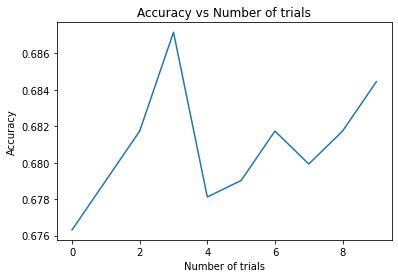

In [9]:
# Plot accuracy
plt.plot(accuracy)
plt.xlabel('Number of trials')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of trials')
plt.show()
